In [1]:
import sys
sys.path.append('../')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from fb_gp import saas_fbgp
import numpy as np
import time
from jaxns.framework.model import Model
from jaxns.framework.prior import Prior
import jax
import tensorflow_probability.substrates.jax as tfp
import jax.numpy as jnp
tfpd = tfp.distributions
from jaxns import NestedSampler, TerminationCondition, resample
from jaxns.framework.model import Model
from jaxns.framework.prior import Prior
from jax import random,vmap, grad
from jax.lax import while_loop

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from acquisition import EI, IPV, optim_scipy_bh
import scipy.optimize
from scipy.stats import qmc
from jaxns import NestedSampler
import corner
from nested_sampler import nested_sampling_jaxns, nested_sampling_Dy
from getdist import plots,MCSamples,loadMCSamples


matplotlib.rc('font', size=16,family='serif')
matplotlib.rc('legend', fontsize=16)

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/cosmo/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


### EI test

In [2]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 8
ndim = 2
train_x_unit = qmc.Sobol(ndim, scramble=True).random(ninit)

def loglike(X):
    logpdf = -0.25*(5*(0.2-X[:,0]))**2 - (20*(X[:,1]/4 - X[:,0]**4))**2
    return logpdf.reshape(-1,1)

param_bounds = np.array([[-1,1],[-1,2]]).T

print(param_bounds[1],param_bounds[0])

# print(param_bounds[0,1])

def input_standardize(x):
    """
    Project from original domain to unit hypercube, X is N x d shaped, param_bounds are 2 x d
    """
    x =  (x - param_bounds[0])/(param_bounds[1] - param_bounds[0])
    return x

def input_unstandardize(x):
    """
    Project from unit hypercube to original domain, X is N x d shaped, param_bounds are 2 x d
    """
    x = x * (param_bounds[1] - param_bounds[0]) + param_bounds[0]
    return x

train_x = input_unstandardize(train_x_unit)

train_y = loglike(train_x)
# print(train_x,train_x_unit)
# print(train_x.shape,train_y.shape)

# train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x_unit,train_y,noise=1e-4)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)


[1 2] [-1 -1]
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:01<00:00, 1016.73it/s, 7 steps of size 3.02e-01. acc. prob=0.85]



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]     27.11     40.12     11.08      0.22     84.81     40.39      0.97
_kernel_inv_length_sq[1]     10.10     28.61      1.30      0.13     17.52     23.46      1.03
        kernel_length[0]      0.32      0.15      0.30      0.14      0.52     25.21      0.98
        kernel_length[1]      0.83      0.90      0.51      0.10      1.69     34.37      0.97
            kernel_tausq      4.62      4.89      2.60      0.11     11.68     29.51      1.02
              kernel_var      6.37      4.08      5.53      1.03     12.93     23.78      0.99

Number of divergences: 0

MCMC elapsed time: 2.75s


In [59]:
nsteps = 32 # 32
mc_points_size = 16
start = time.time()
for i in range(nsteps):
    samples_unit, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    size = len(samples_unit)
    mc_points = samples_unit[::int(size/mc_points_size),:]
    acq_func = EI(gp,gp.train_y.max()) # IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform(0,1,ndim)
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/5,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x_unit = jnp.atleast_2d(results.x)
    next_x = input_unstandardize(next_x_unit)
    next_y = loglike(next_x)
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    train_x_unit = input_standardize(train_x)
    gp = saas_fbgp(train_x_unit,train_y,noise=1e-4)
    gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    print(f"----------------------Step {i+1} complete----------------------\n")


print(f"BO took {time.time() - start:.2f} s ")

Nested Sampling took 1.71s
jaxns did 12151 likelihood evaluations
LogZ info :logz_mean: = -0.8459, dlogz: = 0.3599, 
Acquisition optimization took 1.64 s
Next point at x = [0.6191923  0.13819768] with acquisition function value = -0.1629016063944066


sample: 100%|██████████| 512/512 [00:00<00:00, 637.84it/s, 15 steps of size 2.43e-01. acc. prob=0.87]



MCMC elapsed time: 1.20s
----------------------Step 1 complete----------------------

Nested Sampling took 1.93s
jaxns did 12081 likelihood evaluations
LogZ info :logz_mean: = 2.2498, dlogz: = 0.3370, 
Acquisition optimization took 2.34 s
Next point at x = [0. 1.] with acquisition function value = -0.17700973480962212


sample: 100%|██████████| 512/512 [00:00<00:00, 606.22it/s, 11 steps of size 3.46e-01. acc. prob=0.66]



MCMC elapsed time: 1.24s
----------------------Step 2 complete----------------------

Nested Sampling took 1.76s
jaxns did 11753 likelihood evaluations
LogZ info :logz_mean: = 3.0476, dlogz: = 0.3539, 
Acquisition optimization took 2.11 s
Next point at x = [0.4869522  0.45268717] with acquisition function value = -0.17707548909265597


sample: 100%|██████████| 512/512 [00:00<00:00, 613.46it/s, 7 steps of size 4.81e-01. acc. prob=0.78] 



MCMC elapsed time: 1.33s
----------------------Step 3 complete----------------------

Nested Sampling took 1.72s
jaxns did 12713 likelihood evaluations
LogZ info :logz_mean: = -4.2373, dlogz: = 0.3484, 
Acquisition optimization took 2.19 s
Next point at x = [0.2069106  0.57004563] with acquisition function value = -0.059804056523330235


sample: 100%|██████████| 512/512 [00:00<00:00, 635.72it/s, 31 steps of size 1.81e-01. acc. prob=0.87]



MCMC elapsed time: 1.23s
----------------------Step 4 complete----------------------

Nested Sampling took 1.79s
jaxns did 12511 likelihood evaluations
LogZ info :logz_mean: = -3.9907, dlogz: = 0.3610, 
Acquisition optimization took 2.51 s
Next point at x = [0.7136603 0.       ] with acquisition function value = -0.0592895807019888


sample: 100%|██████████| 512/512 [00:00<00:00, 636.64it/s, 7 steps of size 6.01e-01. acc. prob=0.82] 



MCMC elapsed time: 1.26s
----------------------Step 5 complete----------------------

Nested Sampling took 1.75s
jaxns did 11664 likelihood evaluations
LogZ info :logz_mean: = -2.4293, dlogz: = 0.3540, 
Acquisition optimization took 1.97 s
Next point at x = [0.64123903 0.33544365] with acquisition function value = -0.0310013688131184


sample: 100%|██████████| 512/512 [00:01<00:00, 481.39it/s, 7 steps of size 6.56e-01. acc. prob=0.79]



MCMC elapsed time: 1.61s
----------------------Step 6 complete----------------------

Nested Sampling took 2.23s
jaxns did 11774 likelihood evaluations
LogZ info :logz_mean: = -3.6618, dlogz: = 0.3464, 
Acquisition optimization took 1.39 s
Next point at x = [0. 0.] with acquisition function value = -0.004347283402162374


sample: 100%|██████████| 512/512 [00:01<00:00, 466.31it/s, 7 steps of size 5.27e-01. acc. prob=0.93]



MCMC elapsed time: 1.63s
----------------------Step 7 complete----------------------

Nested Sampling took 2.67s
jaxns did 15527 likelihood evaluations
LogZ info :logz_mean: = 44.8848, dlogz: = 0.4388, 
Acquisition optimization took 1.51 s
Next point at x = [0.71013794 1.        ] with acquisition function value = -0.06419214386188149


sample: 100%|██████████| 512/512 [00:00<00:00, 658.29it/s, 7 steps of size 5.87e-01. acc. prob=0.93] 



MCMC elapsed time: 1.18s
----------------------Step 8 complete----------------------

Nested Sampling took 1.82s
jaxns did 15331 likelihood evaluations
LogZ info :logz_mean: = 52.6391, dlogz: = 0.4373, 
Acquisition optimization took 0.78 s
Next point at x = [1. 0.] with acquisition function value = -0.1425467563342134


sample: 100%|██████████| 512/512 [00:00<00:00, 653.85it/s, 7 steps of size 6.75e-01. acc. prob=0.78] 



MCMC elapsed time: 1.20s
----------------------Step 9 complete----------------------

Nested Sampling took 1.87s
jaxns did 15935 likelihood evaluations
LogZ info :logz_mean: = 3.9577, dlogz: = 0.3393, 
Acquisition optimization took 0.49 s
Next point at x = [0.88661154 0.25769399] with acquisition function value = -1.6890234131005475e-09


sample: 100%|██████████| 512/512 [00:00<00:00, 578.26it/s, 15 steps of size 4.18e-01. acc. prob=0.78]



MCMC elapsed time: 1.30s
----------------------Step 10 complete----------------------

Nested Sampling took 2.65s
jaxns did 15422 likelihood evaluations
LogZ info :logz_mean: = 58.3830, dlogz: = 0.4305, 
Acquisition optimization took 1.71 s
Next point at x = [0.24263184 0.        ] with acquisition function value = -0.19854001503564941


sample: 100%|██████████| 512/512 [00:00<00:00, 625.77it/s, 7 steps of size 4.26e-01. acc. prob=0.90] 



MCMC elapsed time: 1.23s
----------------------Step 11 complete----------------------

Nested Sampling took 3.19s
jaxns did 17694 likelihood evaluations
LogZ info :logz_mean: = 22.8126, dlogz: = 0.3799, 
Acquisition optimization took 1.89 s
Next point at x = [0.32947661 0.23521056] with acquisition function value = -0.03431912310109373


sample: 100%|██████████| 512/512 [00:00<00:00, 617.24it/s, 7 steps of size 4.23e-01. acc. prob=0.93] 



MCMC elapsed time: 1.29s
----------------------Step 12 complete----------------------

Nested Sampling took 2.08s
jaxns did 16664 likelihood evaluations
LogZ info :logz_mean: = 24.8206, dlogz: = 0.3792, 
Acquisition optimization took 2.11 s
Next point at x = [0.88610105 1.        ] with acquisition function value = -0.17788159368032072


sample: 100%|██████████| 512/512 [00:00<00:00, 619.28it/s, 7 steps of size 6.00e-01. acc. prob=0.85]



MCMC elapsed time: 1.25s
----------------------Step 13 complete----------------------

Nested Sampling took 1.97s
jaxns did 16282 likelihood evaluations
LogZ info :logz_mean: = 21.4220, dlogz: = 0.3861, 
Acquisition optimization took 2.37 s
Next point at x = [0.09422823 1.        ] with acquisition function value = -0.009700896530713566


sample: 100%|██████████| 512/512 [00:00<00:00, 628.70it/s, 7 steps of size 5.97e-01. acc. prob=0.88]



MCMC elapsed time: 1.24s
----------------------Step 14 complete----------------------

Nested Sampling took 1.96s
jaxns did 16879 likelihood evaluations
LogZ info :logz_mean: = 13.0756, dlogz: = 0.3734, 
Acquisition optimization took 1.48 s
Next point at x = [0.86404415 0.66740799] with acquisition function value = -0.040831938344378406


sample: 100%|██████████| 512/512 [00:00<00:00, 609.11it/s, 7 steps of size 5.62e-01. acc. prob=0.88] 



MCMC elapsed time: 1.34s
----------------------Step 15 complete----------------------

Nested Sampling took 1.98s
jaxns did 15084 likelihood evaluations
LogZ info :logz_mean: = -0.4468, dlogz: = 0.3370, 
Acquisition optimization took 1.43 s
Next point at x = [0.10366483 0.7374136 ] with acquisition function value = -0.0002547076880875728


sample: 100%|██████████| 512/512 [00:00<00:00, 617.16it/s, 7 steps of size 3.96e-01. acc. prob=0.93]



MCMC elapsed time: 1.23s
----------------------Step 16 complete----------------------

Nested Sampling took 1.98s
jaxns did 15243 likelihood evaluations
LogZ info :logz_mean: = -0.3067, dlogz: = 0.3323, 
Acquisition optimization took 0.57 s
Next point at x = [0.51155724 0.15726365] with acquisition function value = -1.781098876307718e-08


sample: 100%|██████████| 512/512 [00:00<00:00, 610.50it/s, 7 steps of size 4.72e-01. acc. prob=0.92]



MCMC elapsed time: 1.27s
----------------------Step 17 complete----------------------

Nested Sampling took 1.98s
jaxns did 14630 likelihood evaluations
LogZ info :logz_mean: = -0.8022, dlogz: = 0.3167, 
Acquisition optimization took 0.57 s
Next point at x = [0.21164139 0.24394324] with acquisition function value = -1.8203369873808597e-07


sample: 100%|██████████| 512/512 [00:00<00:00, 608.30it/s, 7 steps of size 6.19e-01. acc. prob=0.87] 



MCMC elapsed time: 1.32s
----------------------Step 18 complete----------------------

Nested Sampling took 2.02s
jaxns did 10356 likelihood evaluations
LogZ info :logz_mean: = -1.6473, dlogz: = 0.2942, 
Acquisition optimization took 0.64 s
Next point at x = [0.99995741 1.        ] with acquisition function value = -2.0363918564071626e-07


sample: 100%|██████████| 512/512 [00:00<00:00, 584.52it/s, 7 steps of size 6.84e-01. acc. prob=0.89]



MCMC elapsed time: 1.30s
----------------------Step 19 complete----------------------

Nested Sampling took 2.05s
jaxns did 11182 likelihood evaluations
LogZ info :logz_mean: = -2.0066, dlogz: = 0.3012, 
Acquisition optimization took 0.62 s
Next point at x = [0.36694151 0.45767382] with acquisition function value = -4.90230687109335e-07


sample: 100%|██████████| 512/512 [00:00<00:00, 575.19it/s, 7 steps of size 5.78e-01. acc. prob=0.89]



MCMC elapsed time: 1.33s
----------------------Step 20 complete----------------------

Nested Sampling took 2.01s
jaxns did 10054 likelihood evaluations
LogZ info :logz_mean: = -2.5428, dlogz: = 0.2863, 
Acquisition optimization took 0.59 s
Next point at x = [0.22046235 1.        ] with acquisition function value = -1.0415019762178154e-16


sample: 100%|██████████| 512/512 [00:00<00:00, 548.57it/s, 7 steps of size 6.45e-01. acc. prob=0.85] 



MCMC elapsed time: 1.36s
----------------------Step 21 complete----------------------

Nested Sampling took 2.20s
jaxns did 9939 likelihood evaluations
LogZ info :logz_mean: = -2.2162, dlogz: = 0.2820, 
Acquisition optimization took 0.63 s
Next point at x = [0.41219549 0.23590954] with acquisition function value = -7.501552922868182e-23


sample: 100%|██████████| 512/512 [00:02<00:00, 240.94it/s, 7 steps of size 5.41e-01. acc. prob=0.92]



MCMC elapsed time: 2.61s
----------------------Step 22 complete----------------------

Nested Sampling took 2.11s
jaxns did 10895 likelihood evaluations
LogZ info :logz_mean: = -2.3712, dlogz: = 0.2858, 
Acquisition optimization took 0.59 s
Next point at x = [0.47534365 1.        ] with acquisition function value = -2.7278976851574766e-24


sample: 100%|██████████| 512/512 [00:00<00:00, 546.69it/s, 3 steps of size 5.28e-01. acc. prob=0.92] 



MCMC elapsed time: 1.23s
----------------------Step 23 complete----------------------

Nested Sampling took 2.10s
jaxns did 9413 likelihood evaluations
LogZ info :logz_mean: = -2.7301, dlogz: = 0.2856, 
Acquisition optimization took 0.40 s
Next point at x = [0.33840605 0.43778864] with acquisition function value = -5.949877577820411e-46


sample: 100%|██████████| 512/512 [00:01<00:00, 311.67it/s, 7 steps of size 6.47e-01. acc. prob=0.89] 



MCMC elapsed time: 1.98s
----------------------Step 24 complete----------------------

Nested Sampling took 1.75s
jaxns did 10000 likelihood evaluations
LogZ info :logz_mean: = -2.6452, dlogz: = 0.2872, 
Acquisition optimization took 0.30 s
Next point at x = [0.82456278 0.53167194] with acquisition function value = -1.1973065814776823e-23


sample: 100%|██████████| 512/512 [00:01<00:00, 301.85it/s, 7 steps of size 6.02e-01. acc. prob=0.89] 



MCMC elapsed time: 2.08s
----------------------Step 25 complete----------------------

Nested Sampling took 1.68s
jaxns did 10201 likelihood evaluations
LogZ info :logz_mean: = -2.7441, dlogz: = 0.2874, 
Acquisition optimization took 0.31 s
Next point at x = [0.66823907 0.51413045] with acquisition function value = -3.3780761324166027e-28


sample: 100%|██████████| 512/512 [00:01<00:00, 286.55it/s, 3 steps of size 5.82e-01. acc. prob=0.87] 



MCMC elapsed time: 2.14s
----------------------Step 26 complete----------------------

Nested Sampling took 1.73s
jaxns did 10439 likelihood evaluations
LogZ info :logz_mean: = -2.7275, dlogz: = 0.2855, 
Acquisition optimization took 0.31 s
Next point at x = [0.76487427 0.45863232] with acquisition function value = -2.1559480354250004e-50


sample: 100%|██████████| 512/512 [00:01<00:00, 273.55it/s, 7 steps of size 5.94e-01. acc. prob=0.91] 



MCMC elapsed time: 2.23s
----------------------Step 27 complete----------------------

Nested Sampling took 1.82s
jaxns did 8806 likelihood evaluations
LogZ info :logz_mean: = -2.6222, dlogz: = 0.2741, 
Acquisition optimization took 0.33 s
Next point at x = [0.8841114  0.68889187] with acquisition function value = -7.266333294926266e-22


sample: 100%|██████████| 512/512 [00:01<00:00, 273.88it/s, 7 steps of size 5.80e-01. acc. prob=0.91] 



MCMC elapsed time: 2.30s
----------------------Step 28 complete----------------------

Nested Sampling took 1.71s
jaxns did 9317 likelihood evaluations
LogZ info :logz_mean: = -2.7218, dlogz: = 0.2738, 
Acquisition optimization took 0.31 s
Next point at x = [0.25986607 0.53422388] with acquisition function value = -3.64613101527409e-46


sample: 100%|██████████| 512/512 [00:01<00:00, 274.55it/s, 7 steps of size 5.55e-01. acc. prob=0.91] 



MCMC elapsed time: 2.25s
----------------------Step 29 complete----------------------

Nested Sampling took 1.75s
jaxns did 9926 likelihood evaluations
LogZ info :logz_mean: = -2.8766, dlogz: = 0.2785, 
Acquisition optimization took 0.31 s
Next point at x = [0.08978483 0.78437653] with acquisition function value = -1.6875006449376566e-64


sample: 100%|██████████| 512/512 [00:01<00:00, 277.89it/s, 7 steps of size 5.35e-01. acc. prob=0.92] 



MCMC elapsed time: 2.33s
----------------------Step 30 complete----------------------

Nested Sampling took 1.77s
jaxns did 9777 likelihood evaluations
LogZ info :logz_mean: = -2.9632, dlogz: = 0.2829, 
Acquisition optimization took 0.33 s
Next point at x = [0.31403633 0.        ] with acquisition function value = -4.441649339525671e-68


sample: 100%|██████████| 512/512 [00:01<00:00, 259.78it/s, 3 steps of size 6.29e-01. acc. prob=0.86] 



MCMC elapsed time: 2.37s
----------------------Step 31 complete----------------------

Nested Sampling took 1.72s
jaxns did 9930 likelihood evaluations
LogZ info :logz_mean: = -2.9031, dlogz: = 0.2783, 
Acquisition optimization took 0.41 s
Next point at x = [0.13743495 0.82428091] with acquisition function value = -7.872077117816538e-52


sample: 100%|██████████| 512/512 [00:01<00:00, 261.05it/s, 7 steps of size 6.82e-01. acc. prob=0.87] 



MCMC elapsed time: 2.38s
----------------------Step 32 complete----------------------

BO took 159.67 s 


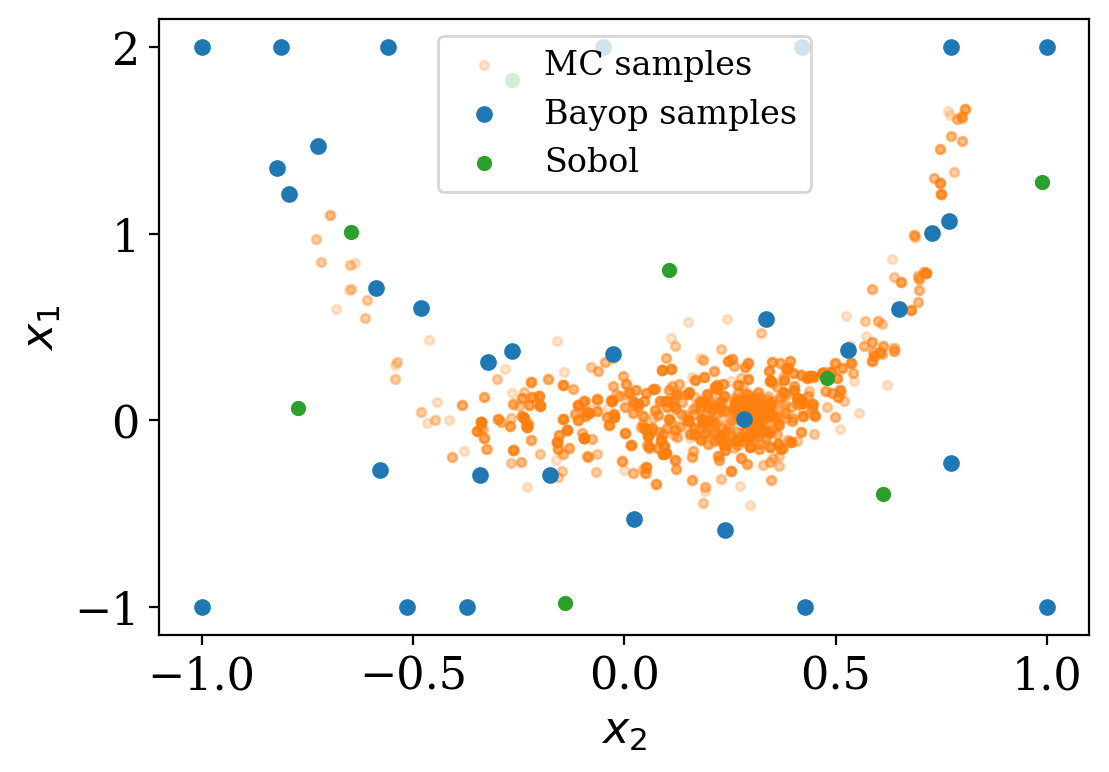

In [60]:
samples = input_unstandardize(samples_unit)

fig,ax = plt.subplots(1,int(ndim/2),figsize=(6,4))
# ax.scatter(samples_unit[:,0],samples_unit[:,0+1],s=10,label='MC samples unit',color='C3',alpha=0.2)
ax.scatter(samples[:,0],samples[:,0+1],s=10,label='MC samples',color='C1',alpha=0.2)
ax.scatter(train_x[ninit:,0],train_x[ninit:,0+1],s=25,label='Bayop samples',color='C0')
ax.scatter(train_x[:ninit,0],train_x[:ninit,0+1],s=20,label='Sobol',color='C2')
ax.set_ylabel(r'$x_1$')
ax.set_xlabel(r'$x_2$')
    # x.axvline(f_mean[2*i],ls='-.',color='k')
    # x.axhline(f_mean[2*i + 1],ls='-.',color='k')
ax.legend(fontsize=12)

In [61]:
samples_unit, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,num_samples_equal=1000,difficult_model=True)
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))
samples = input_unstandardize(samples_unit)

Nested Sampling took 2.70s
jaxns did 145265 likelihood evaluations
LogZ logz_mean: -3.1199, dlogz: 0.1701, 


In [62]:
### Run jaxns directly on loglike

def loglike(X):
    logpdf = -0.25*(5*(0.2-X[0]))**2 - (20*(X[1]/4 - X[0]**4))**2
    return logpdf


def prior_model():
    x = yield Prior(tfpd.Uniform(low=jnp.array([-1,-1]), high= jnp.array([1,2])), name='x')
    return x


model = Model(prior_model=prior_model,log_likelihood=loglike)

model.sanity_check(key=jax.random.PRNGKey(0), S=100)

from jaxns import NestedSampler, TerminationCondition

start = time.time()
ns = NestedSampler(model=model, max_samples=1e5,parameter_estimation=True,difficult_model=True)
term_cond = TerminationCondition(dlogZ=0.01)
# Run the sampler
termination_reason, state = ns(jax.random.PRNGKey(42),term_cond=term_cond)
# Get the results
results = ns.to_results(termination_reason=termination_reason, state=state)
print(f"Nested Sampling took {time.time() - start:.2f}s")
print(f"jaxns did {results.total_num_likelihood_evaluations} likelihood evaluations")
logz_dict = {"logz_mean": results.log_Z_mean, "dlogz": results.log_Z_uncert}
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

samples_jns = resample(key=jax.random.PRNGKey(0),
                    samples=results.samples,
                    log_weights=results.log_dp_mean,
                    S=4000*ndim,
                    replace=True,)
print(samples_jns['x'].shape)

INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


Nested Sampling took 1.83s
jaxns did 150677 likelihood evaluations
LogZ logz_mean: -3.0650, dlogz: 0.1648, 
(8000, 2)


Removed no burn in
Removed no burn in


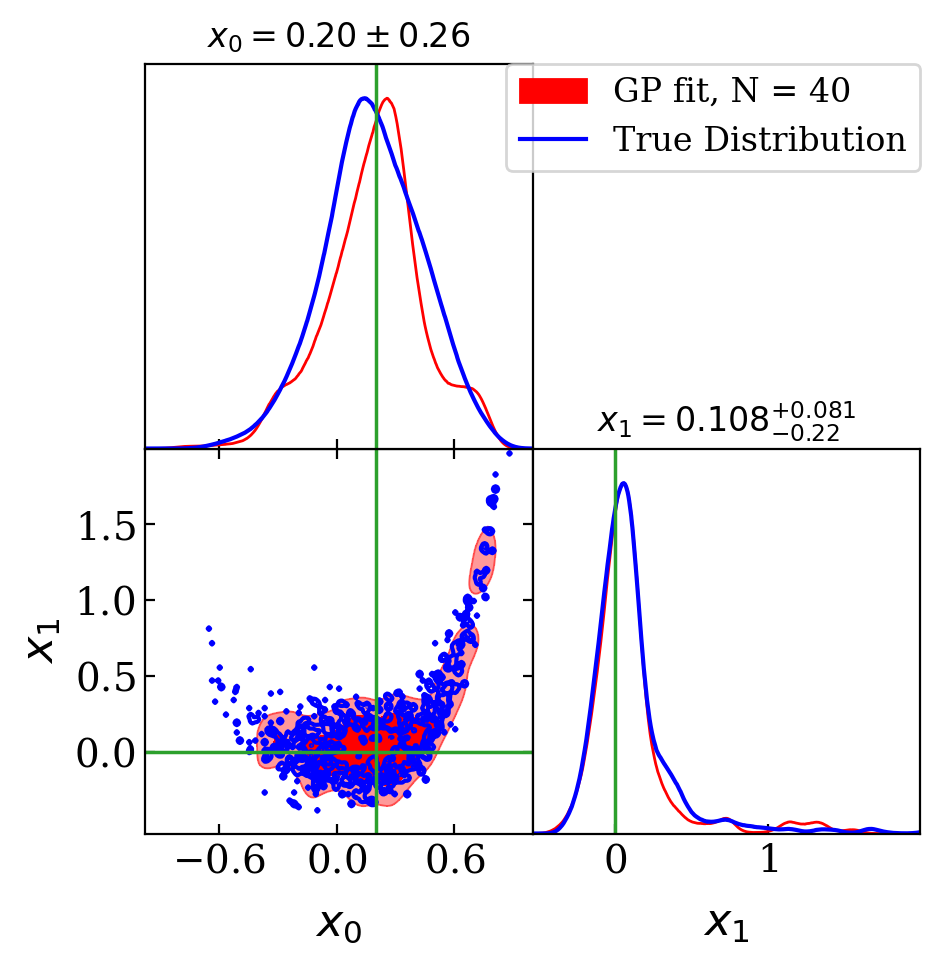

In [63]:
# test_samples = np.random.multivariate_normal(mean=f_mean,cov=cov,size=int(1e5))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  param_bounds.T
f_mean = np.array([0.2,0.])
jns_samples = MCSamples(samples=samples_jns['x'][::4],names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::2],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=2.5,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,jns_samples], names,filled=[True,False],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} ','True Distribution'],
                                contour_lws=[1,1.5],markers = dict(zip(names,f_mean)),
                                marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'},title_limit=1 ) # type: ignore

for i in range(ndim):
    ax = g.subplots[i,i]
    ax.axvline(f_mean[i], color='C2', ls='-',lw=1.25)

### IPV 

In [70]:
train_x_unit = qmc.Sobol(ndim, scramble=True).random(ninit)

train_x = input_unstandardize(train_x_unit)

def loglike(X):
    logpdf = -0.25*(5*(0.2-X[:,0]))**2 - (20*(X[:,1]/4 - X[:,0]**4))**2
    return logpdf.reshape(-1,1)
train_y = loglike(train_x)
print("Testing lightweight implementation")

gp = saas_fbgp(train_x_unit,train_y,noise=1e-4)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)

Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:01<00:00, 888.94it/s, 7 steps of size 3.24e-01. acc. prob=0.89]



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]     41.89     97.07      8.53      0.14     67.36     41.29      0.97
_kernel_inv_length_sq[1]      5.89     18.29      1.91      0.02      6.79     33.08      1.01
        kernel_length[0]      0.21      0.10      0.20      0.06      0.36     16.13      1.09
        kernel_length[1]      0.54      0.40      0.38      0.06      1.04     58.17      0.97
            kernel_tausq     12.76     25.69      2.80      0.05     27.62     16.22      1.02
              kernel_var      5.76      5.32      4.32      0.90     10.81     38.78      0.97

Number of divergences: 0

MCMC elapsed time: 1.67s


In [71]:
nsteps = 32 # 32
mc_points_size = 16
start = time.time()
for i in range(nsteps):
    samples_unit, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    size = len(samples_unit)
    mc_points = samples_unit[::int(size/mc_points_size),:]
    acq_func = IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform(0,1,ndim)
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/5,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x_unit = jnp.atleast_2d(results.x)
    next_x = input_unstandardize(next_x_unit)
    next_y = loglike(next_x)
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    train_x_unit = input_standardize(train_x)
    gp = saas_fbgp(train_x_unit,train_y,noise=1e-4)
    gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    print(f"----------------------Step {i+1} complete----------------------\n")


print(f"BO took {time.time() - start:.2f} s ")

Nested Sampling took 2.07s
jaxns did 13203 likelihood evaluations
LogZ info :logz_mean: = -0.1657, dlogz: = 0.3510, 
Acquisition optimization took 3.07 s
Next point at x = [0.3535952  0.53332941] with acquisition function value = 0.13811313005368592


sample: 100%|██████████| 512/512 [00:01<00:00, 437.29it/s, 11 steps of size 4.58e-01. acc. prob=0.83]



MCMC elapsed time: 1.61s
----------------------Step 1 complete----------------------

Nested Sampling took 2.42s
jaxns did 13475 likelihood evaluations
LogZ info :logz_mean: = -5.1838, dlogz: = 0.3483, 
Acquisition optimization took 3.29 s
Next point at x = [0.5888766  0.24883682] with acquisition function value = 0.052201335768696566


sample: 100%|██████████| 512/512 [00:00<00:00, 531.22it/s, 7 steps of size 3.54e-01. acc. prob=0.85] 



MCMC elapsed time: 1.44s
----------------------Step 2 complete----------------------

Nested Sampling took 1.75s
jaxns did 9033 likelihood evaluations
LogZ info :logz_mean: = 10.4239, dlogz: = 0.3884, 
Acquisition optimization took 2.38 s
Next point at x = [0.96566589 0.98344539] with acquisition function value = 0.022928450745959103


sample: 100%|██████████| 512/512 [00:00<00:00, 569.00it/s, 7 steps of size 3.05e-01. acc. prob=0.87] 



MCMC elapsed time: 1.22s
----------------------Step 3 complete----------------------

Nested Sampling took 1.74s
jaxns did 10939 likelihood evaluations
LogZ info :logz_mean: = 11.5837, dlogz: = 0.3734, 
Acquisition optimization took 2.33 s
Next point at x = [0.2679444  0.04519572] with acquisition function value = 0.017500074178138817


sample: 100%|██████████| 512/512 [00:00<00:00, 612.54it/s, 7 steps of size 3.12e-01. acc. prob=0.83] 



MCMC elapsed time: 1.17s
----------------------Step 4 complete----------------------

Nested Sampling took 1.78s
jaxns did 16347 likelihood evaluations
LogZ info :logz_mean: = -2.9518, dlogz: = 0.3775, 
Acquisition optimization took 2.71 s
Next point at x = [0.56956127 0.30990005] with acquisition function value = 0.014332756456741327


sample: 100%|██████████| 512/512 [00:00<00:00, 587.37it/s, 7 steps of size 4.23e-01. acc. prob=0.74]



MCMC elapsed time: 1.20s
----------------------Step 5 complete----------------------

Nested Sampling took 3.56s
jaxns did 12545 likelihood evaluations
LogZ info :logz_mean: = -4.8023, dlogz: = 0.3446, 
Acquisition optimization took 2.45 s
Next point at x = [0.8353553  0.84642789] with acquisition function value = 0.0005567029705841999


sample: 100%|██████████| 512/512 [00:00<00:00, 534.66it/s, 7 steps of size 4.50e-01. acc. prob=0.83] 



MCMC elapsed time: 1.29s
----------------------Step 6 complete----------------------

Nested Sampling took 1.78s
jaxns did 12316 likelihood evaluations
LogZ info :logz_mean: = 2.5048, dlogz: = 0.3607, 
Acquisition optimization took 2.45 s
Next point at x = [0.92218791 0.71719911] with acquisition function value = 0.0035532038995116783


sample: 100%|██████████| 512/512 [00:00<00:00, 590.14it/s, 15 steps of size 2.38e-01. acc. prob=0.86]



MCMC elapsed time: 1.24s
----------------------Step 7 complete----------------------

Nested Sampling took 1.82s
jaxns did 17435 likelihood evaluations
LogZ info :logz_mean: = 7.2458, dlogz: = 0.3649, 
Acquisition optimization took 2.26 s
Next point at x = [0.20153806 0.69038886] with acquisition function value = 0.05723076813920433


sample: 100%|██████████| 512/512 [00:00<00:00, 658.39it/s, 7 steps of size 5.52e-01. acc. prob=0.90] 



MCMC elapsed time: 1.08s
----------------------Step 8 complete----------------------

Nested Sampling took 1.91s
jaxns did 10872 likelihood evaluations
LogZ info :logz_mean: = 1.3035, dlogz: = 0.3266, 
Acquisition optimization took 2.38 s
Next point at x = [0.46218634 0.54221415] with acquisition function value = 0.011488984470599855


sample: 100%|██████████| 512/512 [00:00<00:00, 641.65it/s, 7 steps of size 6.52e-01. acc. prob=0.83] 



MCMC elapsed time: 1.10s
----------------------Step 9 complete----------------------

Nested Sampling took 1.91s
jaxns did 11257 likelihood evaluations
LogZ info :logz_mean: = -2.8343, dlogz: = 0.3427, 
Acquisition optimization took 2.36 s
Next point at x = [0.88847687 0.96494103] with acquisition function value = 0.01018315855807356


sample: 100%|██████████| 512/512 [00:00<00:00, 541.61it/s, 15 steps of size 3.26e-01. acc. prob=0.95]



MCMC elapsed time: 1.31s
----------------------Step 10 complete----------------------

Nested Sampling took 1.98s
jaxns did 10728 likelihood evaluations
LogZ info :logz_mean: = -2.9939, dlogz: = 0.3275, 
Acquisition optimization took 2.47 s
Next point at x = [0.34788487 0.36238655] with acquisition function value = 0.003190535448173772


sample: 100%|██████████| 512/512 [00:00<00:00, 560.58it/s, 7 steps of size 5.63e-01. acc. prob=0.90]



MCMC elapsed time: 1.28s
----------------------Step 11 complete----------------------

Nested Sampling took 1.90s
jaxns did 12462 likelihood evaluations
LogZ info :logz_mean: = -3.8418, dlogz: = 0.3460, 
Acquisition optimization took 2.87 s
Next point at x = [0.51579424 0.51370789] with acquisition function value = 0.0015214053628422024


sample: 100%|██████████| 512/512 [00:00<00:00, 602.27it/s, 7 steps of size 6.17e-01. acc. prob=0.91]



MCMC elapsed time: 1.23s
----------------------Step 12 complete----------------------

Nested Sampling took 2.03s
jaxns did 11669 likelihood evaluations
LogZ info :logz_mean: = -4.2945, dlogz: = 0.3303, 
Acquisition optimization took 3.01 s
Next point at x = [0.39032557 0.31658564] with acquisition function value = 0.00028361366527693624


sample: 100%|██████████| 512/512 [00:00<00:00, 629.01it/s, 7 steps of size 7.78e-01. acc. prob=0.88]



MCMC elapsed time: 1.14s
----------------------Step 13 complete----------------------

Nested Sampling took 1.90s
jaxns did 12067 likelihood evaluations
LogZ info :logz_mean: = -4.1759, dlogz: = 0.3276, 
Acquisition optimization took 2.47 s
Next point at x = [0.45884446 0.37364385] with acquisition function value = 0.00013502174184279632


sample: 100%|██████████| 512/512 [00:00<00:00, 606.69it/s, 7 steps of size 8.43e-01. acc. prob=0.87]



MCMC elapsed time: 1.20s
----------------------Step 14 complete----------------------

Nested Sampling took 1.99s
jaxns did 9360 likelihood evaluations
LogZ info :logz_mean: = -3.7420, dlogz: = 0.3066, 
Acquisition optimization took 1.50 s
Next point at x = [0.3145744 0.7292065] with acquisition function value = 0.00012546603597394373


sample: 100%|██████████| 512/512 [00:00<00:00, 576.33it/s, 7 steps of size 6.40e-01. acc. prob=0.90]



MCMC elapsed time: 1.25s
----------------------Step 15 complete----------------------

Nested Sampling took 2.01s
jaxns did 8596 likelihood evaluations
LogZ info :logz_mean: = -3.7113, dlogz: = 0.3036, 
Acquisition optimization took 1.45 s
Next point at x = [0.29067117 0.45780714] with acquisition function value = 0.0003299772880361908


sample: 100%|██████████| 512/512 [00:00<00:00, 589.70it/s, 7 steps of size 7.14e-01. acc. prob=0.89]



MCMC elapsed time: 1.27s
----------------------Step 16 complete----------------------

Nested Sampling took 2.00s
jaxns did 10025 likelihood evaluations
LogZ info :logz_mean: = -3.8783, dlogz: = 0.3091, 
Acquisition optimization took 2.52 s
Next point at x = [0.64748612 0.37218585] with acquisition function value = 0.00013379411847474001


sample: 100%|██████████| 512/512 [00:00<00:00, 608.60it/s, 7 steps of size 6.36e-01. acc. prob=0.93]



MCMC elapsed time: 1.13s
----------------------Step 17 complete----------------------

Nested Sampling took 4.93s
jaxns did 8967 likelihood evaluations
LogZ info :logz_mean: = -3.4653, dlogz: = 0.2955, 
Acquisition optimization took 3.11 s
Next point at x = [0.66984791 0.51259264] with acquisition function value = 8.803014141926455e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 452.47it/s, 7 steps of size 8.10e-01. acc. prob=0.90] 



MCMC elapsed time: 1.57s
----------------------Step 18 complete----------------------

Nested Sampling took 2.16s
jaxns did 9115 likelihood evaluations
LogZ info :logz_mean: = -3.4804, dlogz: = 0.2945, 
Acquisition optimization took 2.61 s
Next point at x = [0.38664025 0.17074086] with acquisition function value = 9.838637938112613e-05


sample: 100%|██████████| 512/512 [00:00<00:00, 580.03it/s, 3 steps of size 9.03e-01. acc. prob=0.88] 



MCMC elapsed time: 1.28s
----------------------Step 19 complete----------------------

Nested Sampling took 2.29s
jaxns did 8967 likelihood evaluations
LogZ info :logz_mean: = -3.3745, dlogz: = 0.2923, 
Acquisition optimization took 2.75 s
Next point at x = [0.68939115 0.30954437] with acquisition function value = 9.421998965501374e-05


sample: 100%|██████████| 512/512 [00:00<00:00, 565.33it/s, 7 steps of size 8.20e-01. acc. prob=0.88]



MCMC elapsed time: 1.30s
----------------------Step 20 complete----------------------

Nested Sampling took 2.18s
jaxns did 10376 likelihood evaluations
LogZ info :logz_mean: = -3.1780, dlogz: = 0.2919, 
Acquisition optimization took 1.73 s
Next point at x = [0.49628878 0.26431844] with acquisition function value = 7.182451402096279e-05


sample: 100%|██████████| 512/512 [00:00<00:00, 554.33it/s, 7 steps of size 7.77e-01. acc. prob=0.90]



MCMC elapsed time: 1.30s
----------------------Step 21 complete----------------------

Nested Sampling took 2.21s
jaxns did 9800 likelihood evaluations
LogZ info :logz_mean: = -3.1999, dlogz: = 0.2909, 
Acquisition optimization took 2.22 s
Next point at x = [0.73367815 0.36640764] with acquisition function value = 7.348799813703538e-05


sample: 100%|██████████| 512/512 [00:00<00:00, 522.99it/s, 3 steps of size 7.99e-01. acc. prob=0.91]



MCMC elapsed time: 1.34s
----------------------Step 22 complete----------------------

Nested Sampling took 2.26s
jaxns did 8528 likelihood evaluations
LogZ info :logz_mean: = -3.1168, dlogz: = 0.2896, 
Acquisition optimization took 1.48 s
Next point at x = [0.52403986 0.        ] with acquisition function value = 6.600993013070738e-05


sample: 100%|██████████| 512/512 [00:00<00:00, 554.24it/s, 3 steps of size 7.89e-01. acc. prob=0.91]



MCMC elapsed time: 1.35s
----------------------Step 23 complete----------------------

Nested Sampling took 2.26s
jaxns did 8273 likelihood evaluations
LogZ info :logz_mean: = -3.1200, dlogz: = 0.2870, 
Acquisition optimization took 1.10 s
Next point at x = [0.77508915 0.48493377] with acquisition function value = 5.413063774095672e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 303.68it/s, 7 steps of size 7.35e-01. acc. prob=0.90] 



MCMC elapsed time: 2.28s
----------------------Step 24 complete----------------------

Nested Sampling took 1.89s
jaxns did 8713 likelihood evaluations
LogZ info :logz_mean: = -3.0383, dlogz: = 0.2865, 
Acquisition optimization took 1.31 s
Next point at x = [0.81583    0.38240894] with acquisition function value = 5.61249730759647e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 289.24it/s, 7 steps of size 7.89e-01. acc. prob=0.90] 



MCMC elapsed time: 2.22s
----------------------Step 25 complete----------------------

Nested Sampling took 1.89s
jaxns did 8297 likelihood evaluations
LogZ info :logz_mean: = -2.9669, dlogz: = 0.2822, 
Acquisition optimization took 1.24 s
Next point at x = [0.86138731 0.56102258] with acquisition function value = 5.2747512312482925e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 281.80it/s, 7 steps of size 7.30e-01. acc. prob=0.89] 



MCMC elapsed time: 2.31s
----------------------Step 26 complete----------------------

Nested Sampling took 1.87s
jaxns did 8465 likelihood evaluations
LogZ info :logz_mean: = -2.9887, dlogz: = 0.2822, 
Acquisition optimization took 1.01 s
Next point at x = [0.82357265 0.58904105] with acquisition function value = 8.332493947260655e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 293.72it/s, 3 steps of size 7.80e-01. acc. prob=0.91] 



MCMC elapsed time: 2.25s
----------------------Step 27 complete----------------------

Nested Sampling took 1.79s
jaxns did 8376 likelihood evaluations
LogZ info :logz_mean: = -2.9454, dlogz: = 0.2789, 
Acquisition optimization took 0.87 s
Next point at x = [0.50229887 0.99260944] with acquisition function value = 4.541315067259355e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 303.32it/s, 3 steps of size 9.04e-01. acc. prob=0.86] 



MCMC elapsed time: 2.16s
----------------------Step 28 complete----------------------

Nested Sampling took 1.91s
jaxns did 7978 likelihood evaluations
LogZ info :logz_mean: = -3.1990, dlogz: = 0.2936, 
Acquisition optimization took 0.90 s
Next point at x = [0.68160915 0.74265464] with acquisition function value = 6.329531873447425e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 280.78it/s, 3 steps of size 6.93e-01. acc. prob=0.91] 



MCMC elapsed time: 2.31s
----------------------Step 29 complete----------------------

Nested Sampling took 1.83s
jaxns did 7810 likelihood evaluations
LogZ info :logz_mean: = -3.0959, dlogz: = 0.2895, 
Acquisition optimization took 0.85 s
Next point at x = [0.54718453 0.58499607] with acquisition function value = 4.108483713367167e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 254.18it/s, 7 steps of size 7.51e-01. acc. prob=0.91] 



MCMC elapsed time: 2.53s
----------------------Step 30 complete----------------------

Nested Sampling took 2.00s
jaxns did 7845 likelihood evaluations
LogZ info :logz_mean: = -3.1299, dlogz: = 0.2923, 
Acquisition optimization took 0.95 s
Next point at x = [0.92819963 0.37163491] with acquisition function value = 4.509966204586241e-05


sample: 100%|██████████| 512/512 [00:04<00:00, 110.00it/s, 7 steps of size 6.48e-01. acc. prob=0.93] 



MCMC elapsed time: 5.22s
----------------------Step 31 complete----------------------

Nested Sampling took 2.02s
jaxns did 8042 likelihood evaluations
LogZ info :logz_mean: = -3.0373, dlogz: = 0.2766, 
Acquisition optimization took 0.78 s
Next point at x = [0.51528625 0.69901999] with acquisition function value = 4.241475013888607e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 258.09it/s, 7 steps of size 6.41e-01. acc. prob=0.93] 



MCMC elapsed time: 2.49s
----------------------Step 32 complete----------------------

BO took 187.67 s 


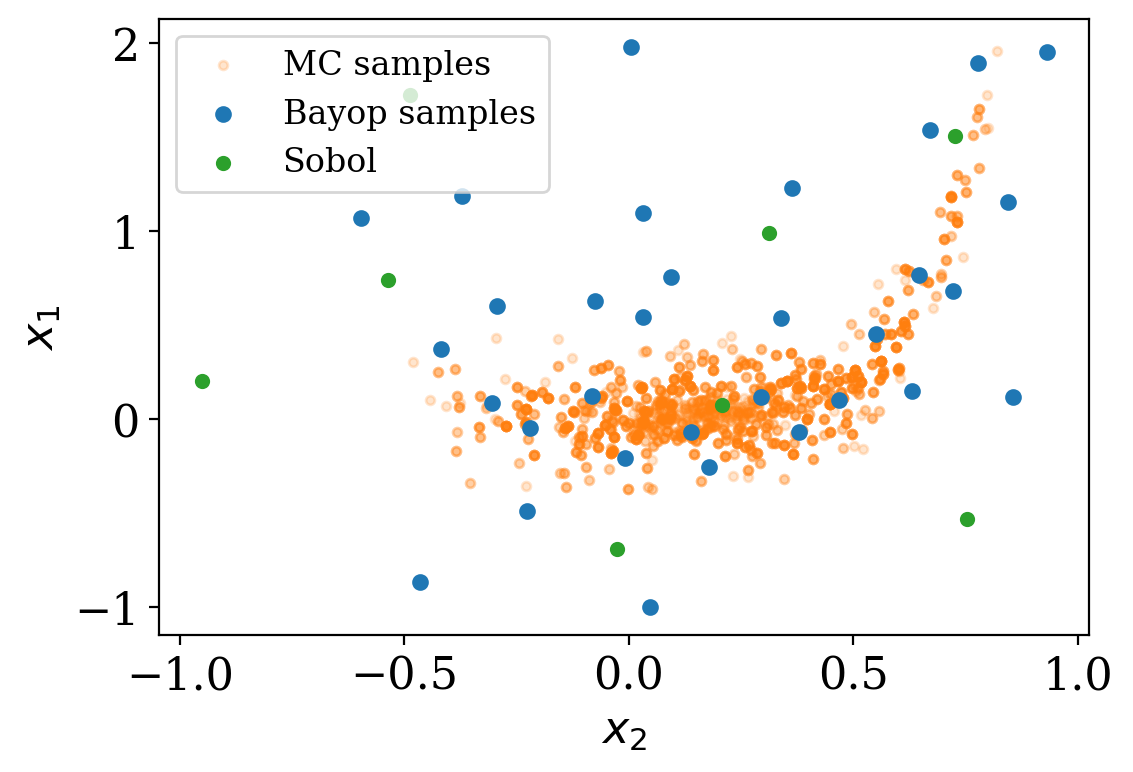

In [72]:
samples = input_unstandardize(samples_unit)

fig,ax = plt.subplots(1,int(ndim/2),figsize=(6,4))
# ax.scatter(samples_unit[:,0],samples_unit[:,0+1],s=10,label='MC samples unit',color='C3',alpha=0.2)
ax.scatter(samples[:,0],samples[:,0+1],s=10,label='MC samples',color='C1',alpha=0.2)
ax.scatter(train_x[ninit:,0],train_x[ninit:,0+1],s=25,label='Bayop samples',color='C0')
ax.scatter(train_x[:ninit,0],train_x[:ninit,0+1],s=20,label='Sobol',color='C2')
ax.set_ylabel(r'$x_1$')
ax.set_xlabel(r'$x_2$')
    # x.axvline(f_mean[2*i],ls='-.',color='k')
    # x.axhline(f_mean[2*i + 1],ls='-.',color='k')
ax.legend(fontsize=12)

In [73]:
samples_unit, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,num_samples_equal=1000,difficult_model=True)
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))
samples = input_unstandardize(samples_unit)

Nested Sampling took 3.28s
jaxns did 152608 likelihood evaluations
LogZ logz_mean: -3.0294, dlogz: 0.1641, 


In [74]:
### Run jaxns directly on loglike

def loglike(X):
    logpdf = -0.25*(5*(0.2-X[0]))**2 - (20*(X[1]/4 - X[0]**4))**2
    return logpdf


def prior_model():
    x = yield Prior(tfpd.Uniform(low=jnp.array([-1,-1]), high= jnp.array([1,2])), name='x')
    return x


model = Model(prior_model=prior_model,log_likelihood=loglike)

model.sanity_check(key=jax.random.PRNGKey(0), S=100)

from jaxns import NestedSampler, TerminationCondition

start = time.time()
ns = NestedSampler(model=model, max_samples=1e5,parameter_estimation=True,difficult_model=True)
term_cond = TerminationCondition(dlogZ=0.01)
# Run the sampler
termination_reason, state = ns(jax.random.PRNGKey(42),term_cond=term_cond)
# Get the results
results = ns.to_results(termination_reason=termination_reason, state=state)
print(f"Nested Sampling took {time.time() - start:.2f}s")
print(f"jaxns did {results.total_num_likelihood_evaluations} likelihood evaluations")
logz_dict = {"logz_mean": results.log_Z_mean, "dlogz": results.log_Z_uncert}
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

samples_jns = resample(key=jax.random.PRNGKey(0),
                    samples=results.samples,
                    log_weights=results.log_dp_mean,
                    S=4000*ndim,
                    replace=True,)
print(samples_jns['x'].shape)

INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


Nested Sampling took 1.90s
jaxns did 150677 likelihood evaluations
LogZ logz_mean: -3.0650, dlogz: 0.1648, 
(8000, 2)


Removed no burn in
Removed no burn in


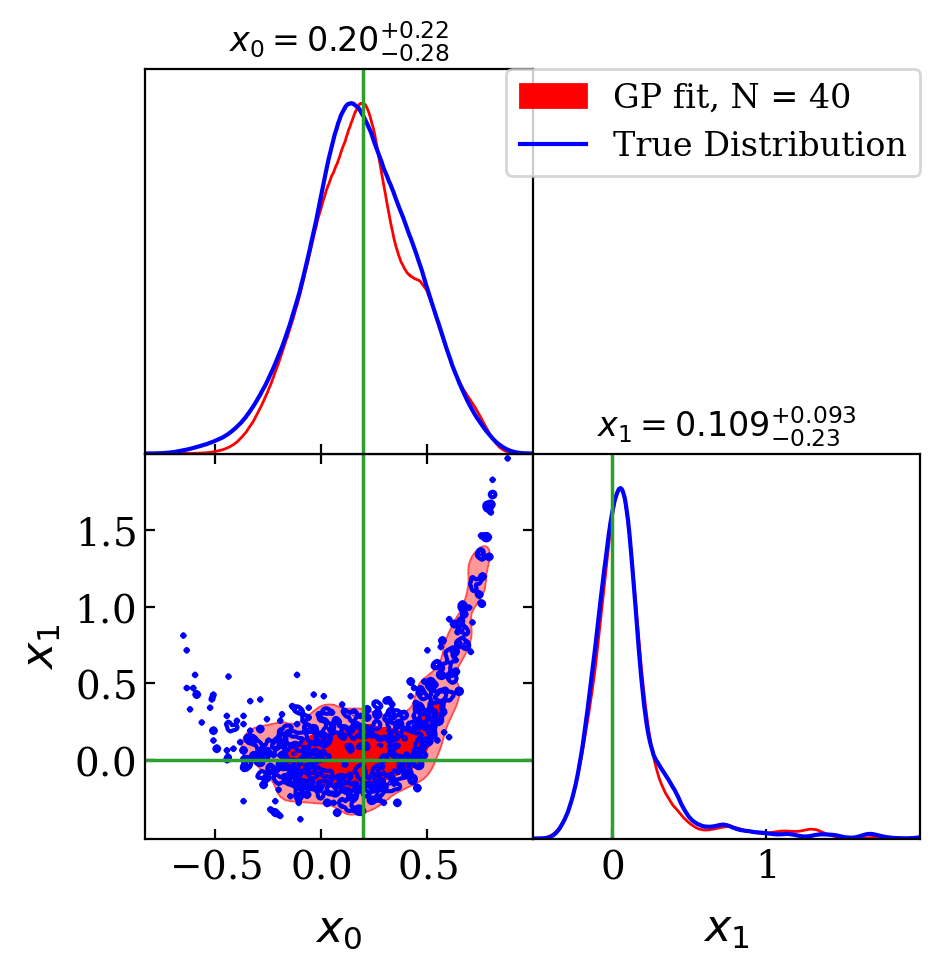

In [75]:
# test_samples = np.random.multivariate_normal(mean=f_mean,cov=cov,size=int(1e5))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  param_bounds.T
f_mean = np.array([0.2,0.])
jns_samples = MCSamples(samples=samples_jns['x'][::4],names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::2],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=2.5,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,jns_samples], names,filled=[True,False],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} ','True Distribution'],
                                contour_lws=[1,1.5],markers = dict(zip(names,f_mean)),
                                marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'},title_limit=1 ) # type: ignore

for i in range(ndim):
    ax = g.subplots[i,i]
    ax.axvline(f_mean[i], color='C2', ls='-',lw=1.25)